In [3]:
# Python imports
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

# Initialize OGGM and set up the run parameters --> Read the configuration file containing the run’s parameters.
cfg.initialize(logging_level='WORKFLOW')

2019-10-03 11:33:42: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [4]:
# Get the RGI glaciers for the run.
rgi_list = ['RGI60-02.07780', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.04264', 'RGI60-02.03688', 'RGI60-02.00147', 'RGI60-02.03411']
rgidf = utils.get_rgi_glacier_entities(rgi_list)

In [5]:
cfg.PARAMS['border'] = 10
cfg.PATHS['working_dir'] = utils.get_temp_dir('test_thick')

In [6]:
gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True, from_prepro_level=3) 

# Gis preprotask is not necessary if you are starting from level 3 - everything is available
# gis_prepro_tasks(gdirs)

2019-10-03 11:33:43: oggm.workflow: init_glacier_regions from prepro level 3 on 7 glaciers.
2019-10-03 11:33:43: oggm.workflow: Execute entity task gdir_from_prepro on 7 glaciers
2019-10-03 11:33:43: oggm.workflow: Multiprocessing: using all available processors (N=8)


In [7]:
# gdirs

In [8]:
# Print the standard MB gradient from OGGM default
from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
gdir = gdirs[2]

mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

In [9]:
# grad_line = np.polyfit(mb_on_z,z,2)
from scipy import stats 
slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

slope: 0.237356    intercept: 2623.495527   R-squared: 0.990997


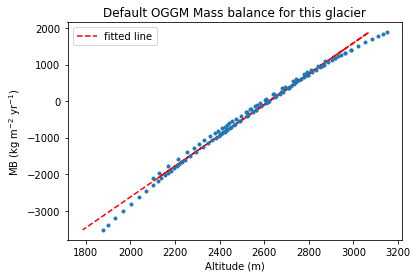

In [10]:
plt.plot(intercept + slope*mb_on_z, mb_on_z, 'r--', label='fitted line');
plt.plot(z, mb_on_z, '.');
plt.title('Default OGGM Mass balance for this glacier');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

In [11]:
mb_on_z[0], z[0]

(1402.5226456339483, 2987.5110218761565)

In [12]:
# See the result of the inversion
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

2019-10-03 11:34:11: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 7 glaciers


In [13]:
import xarray as xr
ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)

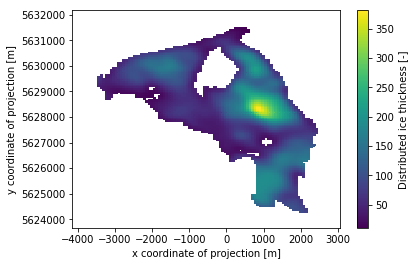

In [14]:
ds_default.distributed_thickness.plot();

In [15]:
# Let's apply a linear MB instead
from oggm.core.climate import apparent_mb_from_linear_mb

# min to max gradients
grad = [5.8, 9.8, 5.9, 9.8, 7.5, 5.3, 5.8] # mm w.e. m-1 
#data points gradients
grad = [6.84, 9.8, 7.11, 9.8, 10.84, 6.01, 7.92] # mm w.e. m-1 

glacier = ['Kokanee', 'Haig', 'Conrad', 'West Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']

for i in range(7):
    gdir = gdirs[i]
    workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[i]);

2019-10-03 11:34:13: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-03 11:34:13: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-03 11:34:13: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-03 11:34:13: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-03 11:34:13: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-03 11:34:13: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-03 11:34:13: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers


{'ela_h': 2582.91795408468, 'grad': 6.84}
{'ela_h': 2670.4536893891946, 'grad': 9.8}
{'ela_h': 2547.6544116847076, 'grad': 7.11}
{'ela_h': 2528.2074934704638, 'grad': 9.8}
{'ela_h': 2497.8304694173885, 'grad': 10.84}
{'ela_h': 2495.3736919704334, 'grad': 6.01}
{'ela_h': 2337.0943128919325, 'grad': 7.92}


/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


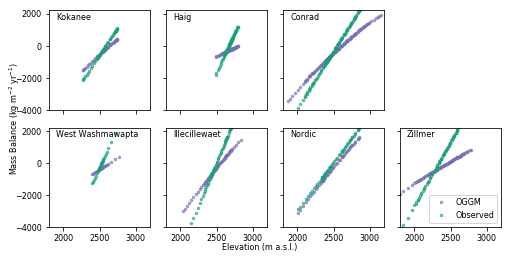

In [16]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

# Compare what we got from this
from oggm.core.massbalance import LinearMassBalance

f, axarr = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(7.04, 3.52))
i, j = 0, 0

for val in range(7):
    gdir = gdirs[val]
    params = gdir.read_pickle('linear_mb_params')
    print(params)

    mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance,
                                         check_calib_params=False)
    z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
    mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR
    
    #max_mb Cap the mass balance to a certain value (unit: [mm w.e. yr-1], we use 2000 mm w.e.
    l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad']) #, max_mb=2000.) 
    l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR


    gdir = gdirs[i]
    axarr[i, j].plot(z, mb_on_z, '.', color='#7570b3', alpha=0.6, markersize=5, label='OGGM'); #markeredgecolor='k');
    axarr[i, j].plot(z, l_mb_on_z, '.', color='#1b9e77', alpha=0.6, markersize=5, label='Observed');
#     axarr[i, j].set_xticklabels(rotation = 45, ha="right")
    plt.xlim(1800, 3200)
    plt.ylim(-4000, 2200)
    axarr[i, j].text(1900, 1600, glacier[val])
    axarr[0, 3].axis('off')
#     plt.xlabel('MB (kg m$^{-2}$ yr$^{-1}$)');
    #     plt.ylabel('Altitude (m)');
#     for tick in axarr[i, j].get_xticklabels():
        #tick.set_rotation(90)
    j += 1

    if val == 2: #changed to 2, 1 worked for 2x2 panel plot
        i += 1
        j = 0
        
plt.legend();   
plt.tight_layout()
# plt.suptitle('MB (kg m$^{-2}$ yr$^{-1}$)', y=0.03, fontsize=12)
plt.suptitle('Elevation (m a.s.l.)', y=0.035, fontsize=8)#ha='center', va ='baseline',
# plt.suptitle('Mass Balance (kg m$^{-2}$ yr$^{-1}$)', x=0.0, y=0.5, rotation='vertical', fontsize=8)
plt.text(-3625, 5650, 'Mass Balance (kg m$^{-2}$ yr$^{-1}$)', rotation='vertical', fontsize=8)

plt.savefig('/home/pelto/Desktop/ice_thick/SMB_gradients_7.png', dpi=300)
plt.show()

In [17]:
slope, intercept, r_value, p_value, std_err = stats.linregress(l_mb_on_z, z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)


slope: 0.126263    intercept: 2337.094313   R-squared: 1.000000


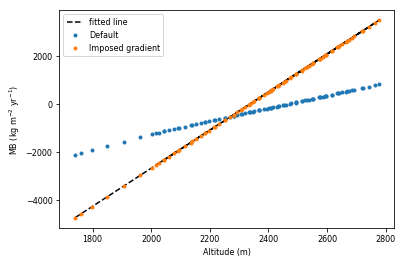

In [18]:
plt.plot(intercept + slope*l_mb_on_z, l_mb_on_z, 'k--', label='fitted line');
plt.plot(z, mb_on_z, '.', label='Default');
plt.plot(z, l_mb_on_z, '.', label='Imposed gradient');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

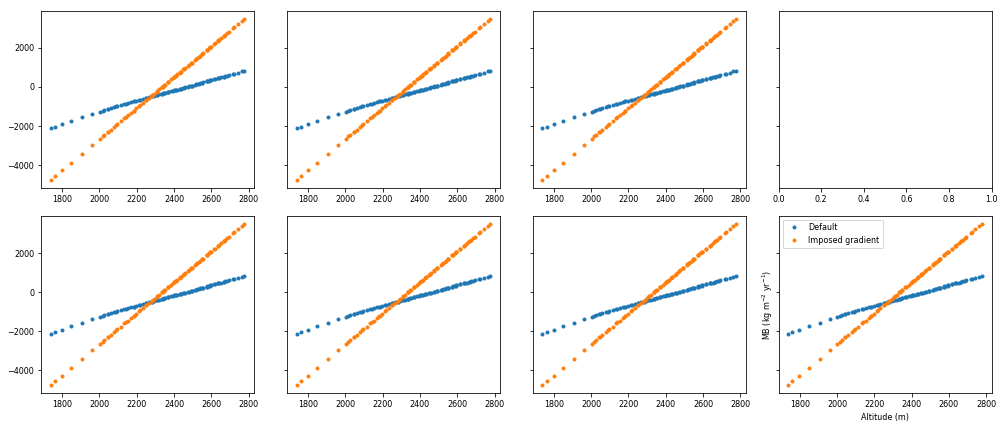

In [19]:

f, axarr = plt.subplots(2, 4, sharey=True, figsize=(14, 6))

i, j = 0, 0

for val in range(7):
    gdir = gdirs[i]
    axarr[i, j].plot(z, mb_on_z, '.', label='Default');
    axarr[i, j].plot(z, l_mb_on_z, '.', label='Imposed gradient');
    plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
    plt.xlabel('Altitude (m)');

    j += 1

    if val == 2: #changed to 2, 1 worked for 2x2 panel plot
        i += 1
        j = 0

plt.legend();   
plt.tight_layout()
plt.savefig('/home/pelto/Desktop/ice_thick/SMB_gradients.png', dpi=600)
plt.show()

In [21]:
utils.compile_glacier_statistics(gdirs, inversion_only=False)

2019-10-03 11:35:09: oggm.workflow: Execute entity task glacier_statistics on 7 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,...,flowline_mean_elev,flowline_max_elev,flowline_min_elev,flowline_avg_width,flowline_avg_slope,t_star,mu_star_glacierwide,mu_star_flowline_avg,mu_star_allsame,mb_bias
rgi_id,,,,,,,,,,,,,,,,,,,,,
RGI60-02.00147,02,02-03,,-117.137,49.7490,1.801,Glacier,Land-terminating,Glacier or ice cap,0.093415,...,2582.917954,2746.576104,2268.645220,1350.074963,0.254657,1953,107.210031,107.210031,True,217.414414
RGI60-02.01857,02,02-03,,-115.301,50.7108,2.585,Glacier,Land-terminating,Glacier or ice cap,0.218632,...,2670.453689,2790.921297,2486.550755,1151.960784,0.152125,1955,48.643157,48.643157,True,287.547872
RGI60-02.02171,02,02-03,,-116.930,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.775652,...,2547.654412,3151.528696,1877.053244,2004.032258,0.190630,1946,110.274153,110.305877,False,298.550866
RGI60-02.03411,02,02-03,,-116.330,51.1770,0.872,Glacier,Land-terminating,Glacier or ice cap,0.036275,...,2528.207493,2769.408852,2397.083095,1354.037267,0.276331,1956,74.311208,74.311208,True,315.301121
RGI60-02.03688,02,02-03,,-117.434,51.2370,5.944,Glacier,Land-terminating,Glacier or ice cap,0.580167,...,2497.830469,2830.994860,2039.689379,1929.870130,0.165791,1937,160.034335,160.034335,True,321.314838
RGI60-02.04264,02,02-03,,-117.710,51.4292,4.425,Glacier,Land-terminating,Glacier or ice cap,0.269818,...,2495.373692,2858.329104,2013.129400,1990.553306,0.306335,1935,151.840873,151.864583,False,320.478366
RGI60-02.07780,02,02-03,,-119.581,52.6705,6.490,Glacier,Land-terminating,Glacier or ice cap,0.425708,...,2337.094313,2777.189914,1738.905206,1550.406116,0.268959,1946,63.827941,63.827941,True,350.451336
